In [1]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from src.functions import get_sents, display_topics
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Read in the transcripts
raw_data_path = './data/raw/ted-talks/'
transcripts_filename = 'transcripts.csv'
t_df = pd.read_csv(raw_data_path+transcripts_filename)
# Pare down the corpus to only those talks with the word 'love'
love=t_df[t_df['transcript'].str.contains(r'\blove',case=False)]
# Tokenize
# Get the collection of n(=5)-sentence snippets with the word 'love'
love_snippets = get_sents(love,'love',0,0)

From results EDA I found that talk ID=132 and 2382 were 'outliers' after dimension reduction was performed when using CountVectorizer(binary=False).  These two talks were songs that mentioned love a lot.  By deleting them I'm trying to capture orthogonal variance in topics modeling to not be dominated by these 2 talks.

In [3]:
# love_snippets.loc[[132, 2382]]

I'll uncomment this when I want those song talks eliminated.

In [4]:
# love_snippets.drop(labels=[132, 2382],inplace=True)

In [5]:
# Topic modeling
# Vectorize
tfidf1 = TfidfVectorizer(stop_words='english', lowercase=True,binary=True)
doc_words_tfidf1 = tfidf1.fit_transform(love_snippets.love)

# Dimension Reduction
tfidf_lsa=[]
tfidf_doc_topic=[]
for i in range(2,7):
    tfidf_lsa.append(TruncatedSVD(i))
    tfidf_doc_topic.append(tfidf_lsa[i-2].fit_transform(doc_words_tfidf1))
    print(int(i),'topics variance ratios:',tfidf_lsa[i-2].explained_variance_ratio_)

2 topics variance ratios: [0.00383013 0.00841552]
3 topics variance ratios: [0.00383012 0.00841532 0.00523836]
4 topics variance ratios: [0.00383007 0.0084153  0.00523893 0.00390973]
5 topics variance ratios: [0.00383012 0.00841537 0.00523603 0.00394339 0.00379021]
6 topics variance ratios: [0.00383012 0.00841522 0.00523903 0.00396223 0.00380875 0.00363145]


In [6]:
display_topics(tfidf_lsa[0], tfidf1.get_feature_names(), 14)


Topic  0
love, loved, people, know, really, like, laughter, just, things, think, thing, said, ve, make

Topic  1
love, labor, vodka, thirds, wires, complexity, mythology, imagining, phrase, museums, action, okay, air, chocolate


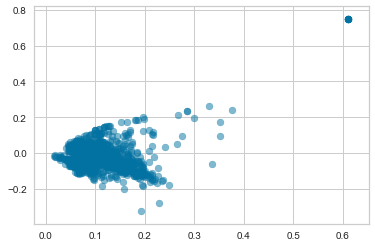

In [7]:
plt.scatter(tfidf_doc_topic[0][:,0],tfidf_doc_topic[0][:,1], alpha = 0.5);
# plt.axis([0, 60, -30, 10])

Investigating the interesting result above seemed  to show that the points in the upper right had longer snippets.  So, I decided to see if there was a relationship with the number of sentences with love in it:

Matplotlib colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

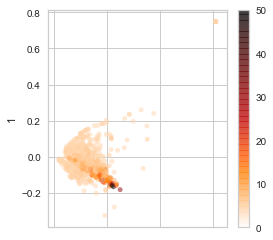

In [8]:
df=pd.DataFrame(tfidf_doc_topic[0])
df.plot.scatter(x=0,y=1,figsize=(4,4), alpha=0.5,\
               c=love_snippets.n_love_sents+3, cmap=plt.get_cmap('gist_heat_r'),vmin=0);

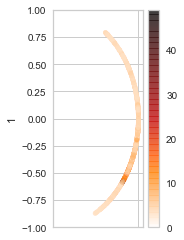

In [9]:
df = pd.DataFrame(normalize(tfidf_doc_topic[0]))
df.plot.scatter(x=0,y=1,figsize=(2,4), alpha=0.5,\
               c=love_snippets.n_love_sents+2, cmap=plt.get_cmap('gist_heat_r'),vmin=0)
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

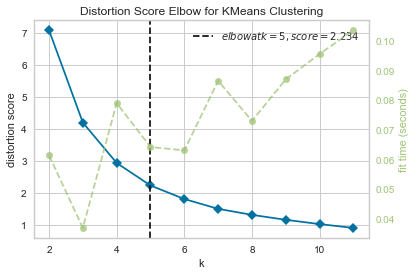

In [10]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(tfidf_doc_topic[0])        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

In [11]:
visualizer.elbow_value_

5

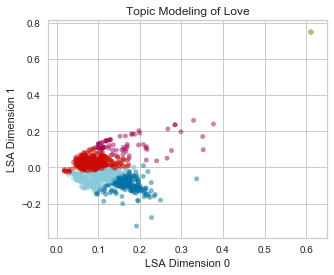

In [12]:
df=pd.DataFrame(tfidf_doc_topic[0],columns=['LSA Dimension 0','LSA Dimension 1'])
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=None,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x='LSA Dimension 0',y='LSA Dimension 1',\
                figsize=(5,4), c=col, alpha = 0.5,title='Topic Modeling of Love');
# plt.axis([-1,1.05,-1,1]);

In [13]:
for i,center in enumerate(km.cluster_centers_):
    print(cmap[i],center)

r [0.08942054 0.02038916]
g [0.61122667 0.74813583]
b [ 0.16951537 -0.0950781 ]
c [ 0.10420807 -0.04811594]
m [0.17111191 0.12878165]


Getting the matrix of euclidean distances from the cluster centers: (used to work that out)

In [14]:
pd.DataFrame(pairwise_distances(km.cluster_centers_,tfidf_doc_topic[0]).T).head()

,0,1,2,3,4
0,0.100226,0.921181,0.043442,0.053295,0.182716
1,0.066876,0.875617,0.097995,0.070098,0.128364
2,0.047088,0.848415,0.163467,0.108088,0.088728
3,0.104202,0.955365,0.045219,0.037104,0.209428
4,0.196729,0.968829,0.057090,0.137240,0.266006


Show the snippets from the 4 (euclidean distance) closest documents:

In [15]:
doc_topic = tfidf_doc_topic[0]
euclidean_distances_to_centers=pd.DataFrame(pairwise_distances(km.cluster_centers_,doc_topic).T)
for i,center in enumerate(km.cluster_centers_):
    n_closest=euclidean_distances_to_centers[i].nsmallest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,cs in n_closest.iteritems():
#         print(j,cs)
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [0.08942054 0.02038916] color= r
233 : [0.09081443 0.02072405] I love cheese!RS: Yeah. I really love cheese sandwiches." And Joshua also really loves cheese sandwiches. I love cheese sandwiches."
699 : [0.08594211 0.02062627] One of my yoga instructors once said that love is attention, and definitely from my grandmother, love and attention were one and the same thing. It threatens the flow of love.
289 : [0.08876557 0.02420505] Don't pretend it isn't.Now, we love to wrap ourselves in lies. We love to do it. I love Big Placebo.
259 : [0.09189426 0.01614684] (Laughter)Now, "All Shook Up" is a great love song. And love is not love, but being all shook up.In this, Elvis is following Aristotle's classic definition of metaphor as the process of giving the thing a name that belongs to something else.


Cluster centered at: [0.61122667 0.74813583] color= g
10 : [0.61122667 0.74813583] I love it.
85 : [0.61122667 0.74813583] Was she in love with him?
201 : [0.61122667 0.748

I'll now project the doc_topic values onto the unit circle, sphere, hypersphere I.  If I don't re-cluster yet, I'm looking at the clustering results from above:

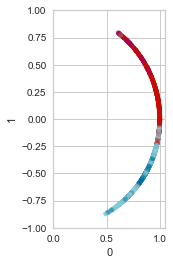

In [16]:
df = pd.DataFrame(normalize(doc_topic))
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

This next cell identifies the documents closest to the cluster centers using cosine similarity.

In [17]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=doc_topic).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [0.08942054 0.02038916] color= r
233 : [0.09081443 0.02072405] I love cheese!RS: Yeah. I really love cheese sandwiches." And Joshua also really loves cheese sandwiches. I love cheese sandwiches."
1008 : [0.06221548 0.01414853] So the Cas9 — I love to anthropomorphize — so the Cas9 is kind of this Pac-Man thing that wants to chew DNA, and the guide RNA is the leash that's keeping it out of the genome until it finds the exact spot where it matches.
682 : [0.13251298 0.0303356 ] It's lovely to see you. Lovely watch, it doesn't come off very well. So we'd love to give you this lovely watch as a gift.
542 : [0.11543278 0.02648626] They start over here — they love people's eyes — and it remains quite stable.


Cluster centered at: [0.61122667 0.74813583] color= g
10 : [0.61122667 0.74813583] I love it.
85 : [0.61122667 0.74813583] Was she in love with him?
201 : [0.61122667 0.74813583] I love that you put it out there.
384 : [0.61122667 0.74813583] I would love to, but w

Now clustering on the 

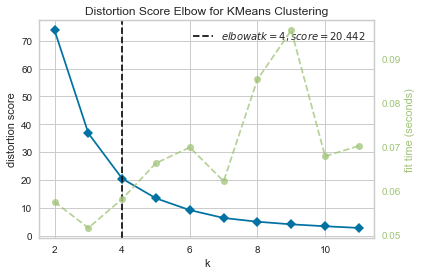

In [18]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

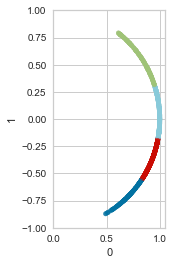

In [19]:
df = pd.DataFrame(normalize(doc_topic))
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

In [20]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.91894859 -0.37882037] color= r
845 : [ 0.92463423 -0.38085633] Think about your reactions when I first came onto the stage, or the prospect of your own blindness, or a loved one going blind. In their own words, I would move out — which I did when I was 18 — I will pay taxes — thanks — (Laughter) — and they knew the difference between love and fear. They put my freedom first before all else, because that is what love does.Now, moving forward, how do I manage today? Louchart: I love being blind.
391 : [ 0.92464851 -0.38082167] And the fact is, people learn from people they love. And we see this when lovers walk down the street, when a crowd in Egypt or Tunisia gets caught up in an emotional contagion, the deep interpenetration. The unconscious mind hungers for those moments of transcendence, when the skull line disappears and we are lost in a challenge or a task — when a craftsman feels lost in his craft, when a naturalist feels at one with nature, when a believe

# The 3-topic Result

In [21]:
display_topics(tfidf_lsa[1], tfidf1.get_feature_names(), 14)


Topic  0
love, loved, people, know, really, like, laughter, just, things, think, thing, said, ve, make

Topic  1
love, labor, wires, vodka, thirds, complexity, mythology, imagining, phrase, museums, action, okay, air, live

Topic  2
loved, really, love, ones, family, concert, told, cook, iphone, detached, sailing, big, sausages, lost


In [22]:
tfidf_doc_topic[1]

array([[ 0.15723717, -0.05342285,  0.05051625],
       [ 0.15360195,  0.00112767, -0.0343337 ],
       [ 0.11589196,  0.05884311, -0.01126556],
       ...,
       [ 0.10527032,  0.05822125, -0.0054221 ],
       [ 0.09739482, -0.00319315, -0.05172981],
       [ 0.12253448,  0.05204778,  0.00149587]])

In [23]:
from mpl_toolkits.mplot3d import Axes3D

In [24]:
# Use this to visualize the un-projected doc-topic space:
# df = pd.DataFrame(cv_doc_topic[1])
# Use this to visualize the projected doc-topic space:
df = pd.DataFrame(normalize(tfidf_doc_topic[1]))

Helpful in getting started with 3D plotting:
* https://pythonprogramming.net/3d-graphing-pandas-matplotlib/
* https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py
* https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

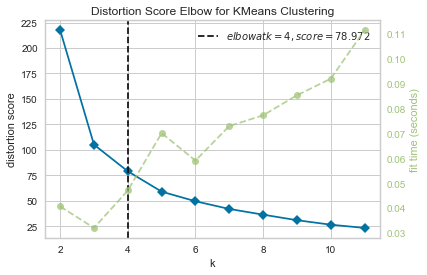

In [25]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [34]:
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


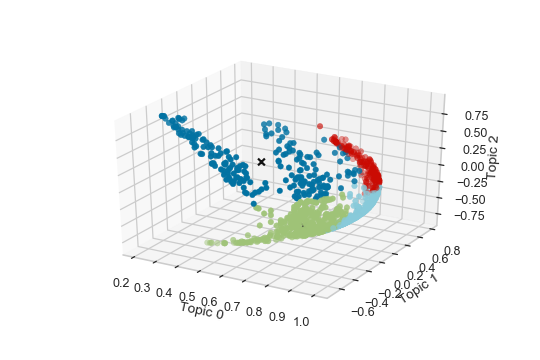

In [35]:
%matplotlib notebook
fig = plt.figure() #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
           marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
fig.show();

So, what do the clusters mean?

In [36]:
doc_topic = tfidf_doc_topic[1]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [0.79764611 0.55677262 0.04463229] color= r
524 : [0.81599152 0.57730458 0.02961858] It's an expression of love. It's an expression of beauty, it's how they say they love you.
1116 : [0.82392477 0.56319222 0.06294839] And I thought: I love this country.
197 : [0.82779363 0.56037991 0.02705659] I love to teach, and it was mentioned by the previous speaker that I enjoy poetry, and I dabble in it a bit, and love it. I love poetry and always had an interest in that somehow.
930 : [0.81104403 0.5799206  0.07680935] Personally, I love handicrafts, especially handicrafts that are woven around a story.


Cluster centered at: [ 0.83291966 -0.39729316 -0.28072729] color= g
1087 : [ 0.85711214 -0.41983602 -0.29849036] Because if you look closely, our education system today is focused more on creating what ex-Yale professor Bill Deresiewicz calls "excellent sheep" — young people who are smart and ambitious, and yet somehow risk-averse, timid, directionless and, sometimes, full

## DBSCAN Clustering

In [37]:
from sklearn.cluster import DBSCAN

In [46]:
db = DBSCAN(eps=0.055, min_samples=5).fit(df)
labels = db.labels_
np.unique(labels,return_counts=True)
# labels = hdbscan.HDBSCAN(
#     min_samples=10,
#     min_cluster_size=500,
# ).fit_predict(clusterable_embedding)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7]),
 array([113, 899,   5,  40,  52,   6,   9,   6,  12]))

In [47]:
cmap = {-1: 'k', 0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow',10:'fuchsia',11:'purple',12:'brown'}
col = pd.DataFrame(np.array([db.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


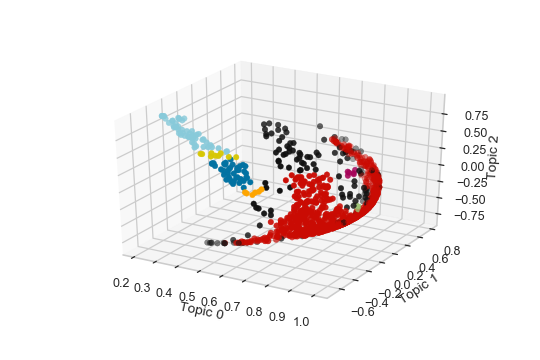

In [48]:
fig = plt.figure() #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
#            marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
fig.show();

## MeanShift Clustering

In [49]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [50]:
# estimate bandwidth for mean shift
bandwidth = estimate_bandwidth(df, quantile=0.09)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(df)
cluster_centers = ms.cluster_centers_
np.unique(ms.labels_,return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([613, 180,  90,  88,  46, 125]))

<IPython.core.display.Javascript object>


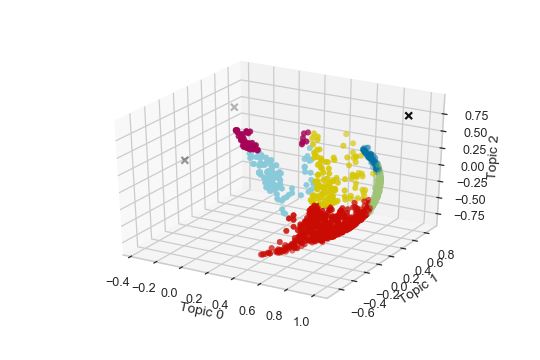

In [51]:
col = pd.DataFrame(np.array([ms.labels_])).transpose()[0].map(cmap)
fig = plt.figure() #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
           marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
fig.show();

## Hierarchical clustering

In [52]:
from sklearn.cluster import AgglomerativeClustering

In [53]:
# linkage can be 'ward', 'average' or 'complete'
hc = AgglomerativeClustering(linkage='average', n_clusters=6)
hc.fit(df)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=6,
                        pooling_func='deprecated')

<IPython.core.display.Javascript object>


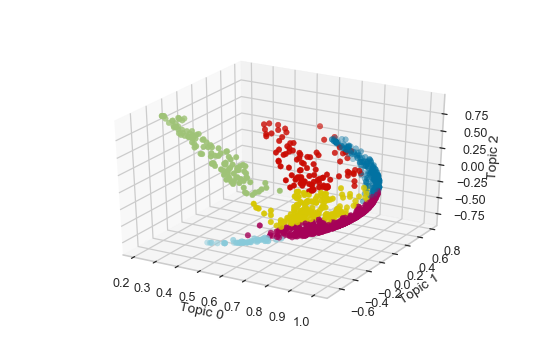

In [54]:
col = pd.DataFrame(np.array([hc.labels_])).transpose()[0].map(cmap)
fig = plt.figure() #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
#            marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
fig.show();

## Spectral Clustering

In [55]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=6)
labels = sc.fit_predict(df)

<IPython.core.display.Javascript object>


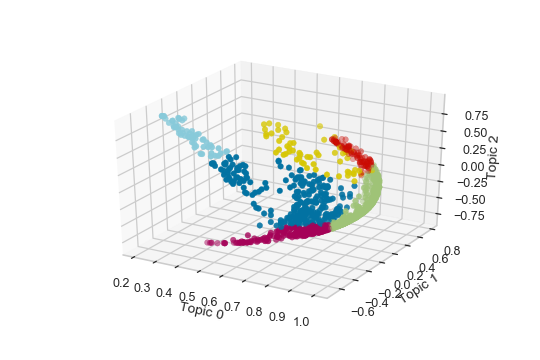

In [56]:
col = pd.DataFrame(np.array([labels])).transpose()[0].map(cmap)
fig = plt.figure() #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
#            marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
fig.show();